In [70]:
import os
import json
from tqdm import tqdm
import warnings
from functools import partial

import numpy as np
import pandas as pd

from dpipe.io import load, save_json
from dpipe.dataset.wrappers import apply, cache_methods
from dpipe.im.metrics import dice_score, iou
from ood.dataset.cc359 import CC359
from ood.dataset.utils import Rescale3D, scale_mri
from ood.paths import CC359_DATA_PATH
from ood.torch.module.unet_mc_dropout import UNet3D_MC_Dropout
from ood.utils import sdice
from ood.metric.ood_metric import calc_ood_scores, get_entropy, get_mutual_info, get_inconsistency_metrics

import matplotlib.pyplot as plt
%matplotlib inline


data_path = CC359_DATA_PATH

# if `voxel_spacing[i]` is `None` when `i`-th dimension will be used without scaling
voxel_spacing = (1, 0.95, 0.95)
sdice_metric = lambda x, y, i: sdice(x, y, dataset.load_spacing(i), 1)

dataset = apply(Rescale3D(CC359(data_path), voxel_spacing), load_image=scale_mri)

in_distr_id = 2
n_folds = 6
ood_folds = [i for i in range(n_folds) if i != in_distr_id]
n_seeds = 5
bin_threshold = 0.5
eps = 1e-8

SEGMENTATION_METRICS = ['dice_score', 'sdice_score', 'froc_records']
SINGLE_NN_OOD_METRICS = ['maxprob', 'entropy']
SPATIAL_DIMS = (-3, -2, -1)


import os
from collections import defaultdict
from typing import Sequence, Callable

import numpy as np
from tqdm import tqdm
from skimage.measure import label

from dpipe.commands import load_from_folder
from dpipe.io import save_json, load_pred, save, load
from dpipe.im.metrics import dice_score
from dpipe.im.box import get_centered_box
from dpipe.im.shape_ops import crop_to_box
from dpipe.itertools import zip_equal
from ood.utils import volume2diameter, get_pred
from ood.batch_iter.pipeline import SPATIAL_DIMS, sample_center_uniformly

In [2]:
import numpy as np

from dpipe.dataset.wrappers import apply, cache_methods
from ood.dataset.gamma_knife import GammaKnife, Rescale3D, RotateImage
from ood.dataset.utils import scale_mri
from ood.paths import GAMMA_KNIFE_MET_T1_T1C_PATH, GAMMA_KNIFE_BRAIN_PATH


data_path_met = GAMMA_KNIFE_MET_T1_T1C_PATH
data_path_brain = GAMMA_KNIFE_BRAIN_PATH

# if `voxel_spacing[i]` is `None` when `i`-th dimension will be used without scaling
# voxel_spacing = (None, None, None)
voxel_spacing = (1, 0.95, 0.95)  # as in CC359; the original GK spacing is close to the CC359 spacing.

preprocessed_dataset = apply(RotateImage(Rescale3D(GammaKnife(data_path_met, 'metadata_30Oct2021.csv', 'SeriesInstanceUID'), 
                                                   voxel_spacing)), load_image=scale_mri, load_t1_image=scale_mri)
dataset_gk = apply(cache_methods(apply(preprocessed_dataset, load_image=np.float16, load_t1_image=np.float16), maxsize=30), 
                load_image=np.float32, load_t1_image=np.float32)

preprocessed_dataset_brain = apply(RotateImage(Rescale3D(GammaKnife(data_path_brain, 'meta.csv'), 
                                                         voxel_spacing)), load_image=scale_mri, load_t1_image=scale_mri)
dataset_brain = apply(cache_methods(apply(preprocessed_dataset_brain, load_image=np.float16, load_t1_image=np.float16),
                                    maxsize=30), load_image=np.float32, load_t1_image=np.float32)

## Dice drop with domain shift

In [8]:
for metric_name in ['dice_score', 'sdice_score']:
    print(f'\n{metric_name}\n')
    
    ood_metrics = np.zeros((n_folds, n_seeds))

    for seed in range(n_seeds):
        base_dir = os.path.join(experiment_dir, f'seed{seed}/experiment_0/')
        metrics = load(os.path.join(base_dir, 'test_metrics', f'{metric_name}.json'))

        ids = set(dataset.df[dataset.df['fold'] == in_distr_id].index)
        metric_keys = set(metrics.keys())
        ids = metric_keys.intersection(ids)

        in_distr_metric = np.mean([metrics[uid] for uid in ids])
        ids = list(ids)
        print(ids[np.argmax([metrics[uid] for uid in ids])], max([metrics[uid] for uid in ids]))
        ood_metrics[in_distr_id, seed] = in_distr_metric
        print(f'In distribution: {in_distr_metric:.4f}')

        for fold_id in ood_folds:
            ids = list(dataset.df[dataset.df['fold'] == fold_id].index)

            ood_metric = np.mean([metrics[uid] for uid in ids])
            print(ids[np.argmin([metrics[uid] for uid in ids])], min([metrics[uid] for uid in ids]))
            ood_metrics[fold_id, seed] = ood_metric
            print(f'OOD fold {fold_id}: {ood_metric:.4f}')

    means = ood_metrics.mean(axis=1)
    stds = ood_metrics.std(axis=1)
    drops = ood_metrics[in_distr_id] - ood_metrics[ood_folds].mean(axis=0)

    for i in range(n_folds):
        print(f'Fold {i}:\tood = {i != in_distr_id}\t{means[i]:.4f} ± {1.96 * stds[i]:.4f}')

    print()
    print(f'In distr:\t\t{means[in_distr_id]:.4f} ± {1.96 * stds[in_distr_id]:.4f}')
    print(f'OOD:\t\t\t{ood_metrics[ood_folds].mean():.4f} ± {1.96 * ood_metrics[ood_folds].std():.4f}')
    print(f'{metric_name} drop:\t{drops.mean():.4f} ± {1.96 * drops.std():.4f}')


dice_score

CC0246 0.9894898913420636
In distribution: 0.9862
CC0130 0.9278166355882047
OOD fold 0: 0.9786
CC0201 0.8971555586639501
OOD fold 1: 0.9749
CC0339 0.678331473062735
OOD fold 3: 0.9346
CC0024 0.9744732603087322
OOD fold 4: 0.9863
CC0091 0.8454000101609732
OOD fold 5: 0.9603
CC0246 0.9896084653652084
In distribution: 0.9864
CC0130 0.8839839653967144
OOD fold 0: 0.9765
CC0201 0.8866167514528063
OOD fold 1: 0.9714
CC0339 0.6999212860939227
OOD fold 3: 0.9271
CC0046 0.9794806552771667
OOD fold 4: 0.9856
CC0091 0.8918368456143888
OOD fold 5: 0.9706
CC0246 0.9894597246977324
In distribution: 0.9860
CC0130 0.8877933970369906
OOD fold 0: 0.9764
CC0201 0.8849234246720257
OOD fold 1: 0.9689
CC0339 0.7431019258287271
OOD fold 3: 0.9431
CC0046 0.9757000585823081
OOD fold 4: 0.9855
CC0091 0.8904678829722568
OOD fold 5: 0.9667
CC0246 0.9894153267905617
In distribution: 0.9861
CC0132 0.8798039718634648
OOD fold 0: 0.9698
CC0201 0.8771208277371536
OOD fold 1: 0.9684
CC0339 0.68214389578252

## Baseline OOD (softmax)

In [5]:
for ue_method in['maxprob', 'entropy']:
    print(f'\n{ue_method}\n')
    det_accs = []
    roc_aucs = []
    tprs = []
    labels_list = []

    for seed in range(n_seeds):
        base_dir = os.path.join(experiment_dir, f'seed{seed}/experiment_0/test_predictions')
        labels = load(os.path.join(experiment_dir, f'seed{seed}/experiment_0/test_metrics/{ue_method}.json'))
        labels_list.append(labels)

        is_ood_true = np.array([dataset.df.fold[uid] != in_distr_id for uid in labels.keys()])
        det_acc, roc_auc, tpr = calc_ood_scores(np.array(list(labels.values())), is_ood_true)
        det_accs.append(det_acc)
        roc_aucs.append(roc_auc)
        tprs.append(tpr)

    print()
    print(f'Detection accuracy:\t{np.mean(det_accs):.4f} ± {1.96 * np.std(det_accs):.4f}')
    print(f'AUROC:\t{np.mean(roc_aucs):.4f} ± {1.96 * np.std(roc_aucs):.4f}')
    print(f'TNR @ 95% TPR:\t{np.mean(tprs):.4f} ± {1.96 * np.std(tprs):.4f}')

    print('\nMean labels')
    final_labels = {}
    for key in labels_list[0].keys():
        score = 0
        for labels in labels_list:
            score += labels[key]
        score /= len(labels_list)
        final_labels[key] = score

    is_ood_true = np.array([dataset.df.fold[uid] != in_distr_id for uid in final_labels.keys()])
    det_acc, roc_auc, tpr = calc_ood_scores(np.array(list(final_labels.values())), is_ood_true)


maxprob

Detection accuracy: 0.7609
AUROC: 0.7783
TNR @ 95% TPR: 0.5619
Detection accuracy: 0.7777
AUROC: 0.8080
TNR @ 95% TPR: 0.5686
Detection accuracy: 0.7730
AUROC: 0.8064
TNR @ 95% TPR: 0.5452
Detection accuracy: 0.7978
AUROC: 0.8376
TNR @ 95% TPR: 0.6087
Detection accuracy: 0.7978
AUROC: 0.8172
TNR @ 95% TPR: 0.5518

Detection accuracy:	0.7814 ± 0.0283
AUROC:	0.8095 ± 0.0376
TNR @ 95% TPR:	0.5672 ± 0.0436

Mean labels
Detection accuracy: 0.7763
AUROC: 0.8143
TNR @ 95% TPR: 0.5786

entropy

Detection accuracy: 0.7593
AUROC: 0.7851
TNR @ 95% TPR: 0.5518
Detection accuracy: 0.7678
AUROC: 0.8071
TNR @ 95% TPR: 0.5585
Detection accuracy: 0.7730
AUROC: 0.8136
TNR @ 95% TPR: 0.5485
Detection accuracy: 0.7944
AUROC: 0.8328
TNR @ 95% TPR: 0.5953
Detection accuracy: 0.7811
AUROC: 0.8142
TNR @ 95% TPR: 0.5552

Detection accuracy:	0.7751 ± 0.0235
AUROC:	0.8106 ± 0.0301
TNR @ 95% TPR:	0.5619 ± 0.0334

Mean labels
Detection accuracy: 0.7763
AUROC: 0.8161
TNR @ 95% TPR: 0.5619


In [3]:
def visualize_ood_statistics(labels, metrics):
    ood_metrics = np.zeros((n_folds))

    ids = set(dataset.df[dataset.df['fold'] == in_distr_id].index)
    metric_keys = set(metrics.keys())
    ids = metric_keys.intersection(ids)

    in_distr_metric = np.mean([metrics[uid] for uid in ids])
    ood_metrics[in_distr_id] = in_distr_metric
    print(f'In distribution: {in_distr_metric:.4f}')

    for fold_id in ood_folds:
        ids = list(dataset.df[dataset.df['fold'] == fold_id].index)

        ood_metric = np.mean([metrics[uid] for uid in ids])
        ood_metrics[fold_id] = ood_metric
        print(f'OOD fold {fold_id}: {ood_metric:.4f}')

    labels_arr = np.array(list(labels.values()))
    folds = np.array([dataset.df.fold[uid] for uid in labels.keys()])
    is_ood_true = np.array([dataset.df.fold[uid] != in_distr_id for uid in labels.keys()])
    sorted_ids = np.argsort(labels_arr)
    print(is_ood_true[sorted_ids])
    print(folds[sorted_ids])

    ordered_metrics = {uid: metrics[uid] for uid in labels.keys()}
    ordered_metrics_arr = np.array(list(ordered_metrics.values()))

    for fold in range(n_folds):
        plt.hist(labels_arr[folds == fold], alpha=0.5, 
                 label=f'{fold}: sdice drop {(ood_metrics[in_distr_id] - ood_metrics[fold]):.3f}')

    plt.title('Histogram with uncertainty scores for different domains')
    plt.xlabel('Uncertainty score')
    plt.legend()
    plt.show()

    for fold in range(n_folds):
        plt.scatter(labels_arr[folds == fold], ordered_metrics_arr[folds == fold], alpha=1, 
                    label=f'{fold}: sdice drop {(ood_metrics[in_distr_id] - ood_metrics[fold]):.3f}')

    plt.title('Dependence between segmentation quality and uncertainty score')
    plt.xlabel('Uncertainty score')
    plt.ylabel('Surface dice')
    plt.legend()
    plt.grid()
    plt.show()

In distribution: 0.9862
OOD fold 0: 0.9786
OOD fold 1: 0.9749
OOD fold 3: 0.9346
OOD fold 4: 0.9863
OOD fold 5: 0.9603
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True False  True  True  True  True
 False  True  True False  True False False  True  True False  True  True
  True  True False  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True False  True  True  True  True  True
  True  True False False  True  True  True False False  True  True False
  True False  True  True  True  True  True  True  True False  True  True
  True False  True  True False  True  True  True  True  True False  True
  True False False  True False  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  Tru

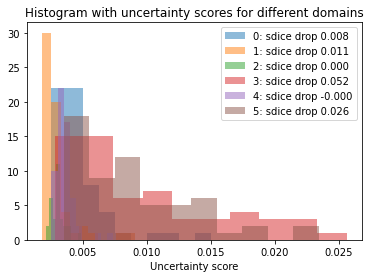

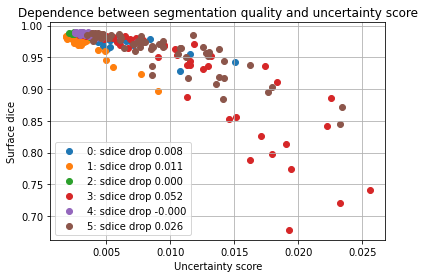

In [4]:
seed = 0
labels = load(os.path.join(experiment_dir, f'seed{seed}/experiment_0/test_metrics/maxprob.json'))
metrics = load(os.path.join(experiment_dir, f'seed{seed}/experiment_0/test_metrics/dice_score.json'))

visualize_ood_statistics(labels, metrics)

### Ensemble

In [5]:
def save_ensemble_metrics(exp_dir, has_targets=False, load_y=None):
    dices = {}
    sdices = {}
    ensemble_labels = {}

    base_dir = os.path.join(exp_dir, f'seed0/experiment_0/test_predictions')
    filenames = os.listdir(base_dir)
    uids = ['.'.join(fname.split('.')[:-1]) for fname in filenames]

    for uid in tqdm(uids):
        ensemble_preds = []
        for seed in range(n_seeds):
            base_dir = os.path.join(exp_dir, f'seed{seed}/experiment_0/test_predictions')
            preds = load(os.path.join(base_dir, uid + '.npy')).astype(np.float32)
            ensemble_preds.append(preds)

        ensemble_preds = np.array(ensemble_preds)
        mean_preds = ensemble_preds.mean(axis=0)
        ensemble_labels[uid] = get_inconsistency_metrics(ensemble_preds, top_n_voxels=TOP_N_VOXELS)
        # get segmentation metrics
        
        if has_targets:
            true_mask = load_y(uid)
            dices[uid] = dice_score(mean_preds > bin_threshold, true_mask > bin_threshold)
            sdices[uid] = sdice_metric(mean_preds > bin_threshold, true_mask > bin_threshold, uid)

    # save results
    results = ensemble_labels
    results_path = os.path.join(exp_dir, 'final_metrics')
    os.makedirs(results_path, exist_ok=True)

    for agg_func_name in results[list(results.keys())[0]].keys():
        result = {_id: results[_id][agg_func_name] for _id in results.keys()}
        save_json(result, os.path.join(results_path, agg_func_name + '.json'), indent=0)

    if has_targets:
        save_json(dices, os.path.join(results_path, 'dice_score.json'), indent=0)
        save_json(sdices, os.path.join(results_path, 'sdice_score.json'), indent=0)

In [70]:
load_y = lambda uid: dataset.load_segm(uid)
save_ensemble_metrics(experiment_dir, load_y=load_y, has_targets=True)

In [83]:
k = 1 # angle of rotation (90 degrees)
load_y = lambda uid: np.rot90(dataset.load_segm(uid), k=k, axes=(SPATIAL_DIMS[0], SPATIAL_DIMS[1]))
save_ensemble_metrics('/shared/experiments/ood_playground/cc359/crops_and_flips/rot/', 
                      load_y=load_y, has_targets=True)

100%|██████████| 30/30 [07:32<00:00, 15.09s/it]


In [41]:
ax = 1
load_y = lambda uid: np.flip(dataset.load_segm(uid), axis=SPATIAL_DIMS[:2][ax])
save_ensemble_metrics('/shared/experiments/ood_playground/cc359/crops_and_flips/vertical_flip/', 
                      load_y=load_y, has_targets=True)

100%|██████████| 30/30 [08:06<00:00, 16.20s/it]

{'CC0286': {'std': 0.0009329065, 'var': 7.6957505e-05, 'mean_iou': 0.007418424504530274, 'mean_dice': 0.003723047089855469, 'mean_volume': 0.0014584678409754063, 'top_n_500000_std': 0.0, 'top_n_1000000_std': 0.00011177243, 'top_n_2000000_std': 0.006551927, 'top_n_500000_var': 0.0, 'top_n_1000000_var': 1.2409606e-07, 'top_n_2000000_var': 0.00054585777, 'mut_info': 0.00042712977}, 'CC0252': {'std': 0.0015376691, 'var': 0.0001369621, 'mean_iou': 0.009333929647516736, 'mean_dice': 0.004688877380861811, 'mean_volume': 0.0013296517419329713, 'top_n_500000_std': 0.0, 'top_n_1000000_std': 1.687837e-05, 'top_n_2000000_std': 0.010805275, 'top_n_500000_var': 0.0, 'top_n_1000000_var': 4.08432e-09, 'top_n_2000000_var': 0.0009714563, 'mut_info': 0.0007830656}, 'CC0280': {'std': 0.0017385214, 'var': 0.00015291941, 'mean_iou': 0.00781586330745121, 'mean_dice': 0.0039233124401279575, 'mean_volume': 0.0009430187523110277, 'top_n_500000_std': 0.0, 'top_n_1000000_std': 0.0, 'top_n_2000000_std': 0.01195900

In [85]:
ax = 0
load_y = lambda uid: np.flip(dataset.load_segm(uid), axis=SPATIAL_DIMS[:2][ax])
save_ensemble_metrics('/shared/experiments/ood_playground/cc359/crops_and_flips/horizontal_flip/', 
                      load_y=load_y, has_targets=True)

100%|██████████| 30/30 [07:38<00:00, 15.30s/it]


In [ ]:
save_ensemble_metrics('/shared/experiments/ood_playground/cc359/gamma_knife_t1/no_segm_metrics/')

 82%|████████▏ | 311/379 [25:19<05:28,  4.84s/it]

In [81]:
save_ensemble_metrics('/shared/experiments/ood_playground/cc359/crops_and_flips/crop_preds/')

100%|██████████| 150/150 [08:33<00:00,  3.42s/it]


In [6]:
def get_score_augmentation(true_labels, augm_labels, print_results=True, is_segm_metric=False):
    if type(augm_labels) == dict:
        augm_labels = list(augm_labels.values())
    scores = np.array(list(true_labels.values()) + augm_labels)
    y_true = np.array([False] * len(true_labels) + [True] * len(augm_labels))
    if is_segm_metric:
        y_true = ~y_true
    return calc_ood_scores(scores, y_true, print_results=print_results)


def filter_metrics(metrics, ids):
    return {uid: metrics[uid] for uid in ids}

In [7]:
def add_row(result_df, row_list):
    for i in range(len(row_list)):
        if type(row_list[i]) == np.float64:
            row_list[i] = np.round(row_list[i], 4)
    result_df.loc[result_df.shape[0]] = row_list


def calc_ood_statistics_new_dataset(result_df, ind_exp_dir, ood_exp_dir, method_name, ind_ids=None, 
                                    has_single_ue_scores=True, has_incosnsistency_scores=True):
        
    metric_file = os.listdir(ind_exp_dir)[0]
    ind_labels = load(os.path.join(ind_exp_dir, metric_file))
    if ind_ids is None:
        ind_ids = list(ind_labels.keys())

    if has_single_ue_scores:
        for metric_name in SINGLE_NN_OOD_METRICS:
            ind_labels = load(os.path.join(ind_exp_dir, metric_name + '.json'))
            ind_labels = filter_metrics(ind_labels, ind_ids)
            ood_labels = load(os.path.join(ood_exp_dir, metric_name + '.json'))
            det_acc, auc, tnr = get_score_augmentation(ind_labels, ood_labels, print_results=False)
            add_row(result_df, [method_name, metric_name, det_acc, auc, tnr])

    if has_incosnsistency_scores:
        for metric_file in os.listdir(ind_exp_dir):
            metric_name = metric_file.split('.json')[0]
            if metric_name in SEGMENTATION_METRICS or metric_name in SINGLE_NN_OOD_METRICS:
                continue
            ind_labels = load(os.path.join(ind_exp_dir, metric_name + '.json'))
            ind_labels = filter_metrics(ind_labels, ind_ids)
            ood_labels = load(os.path.join(ood_exp_dir, metric_name + '.json'))
            det_acc, auc, tnr = get_score_augmentation(ind_labels, ood_labels, print_results=False)
            add_row(result_df, [method_name, metric_name, det_acc, auc, tnr])
            
            
def calc_ood_statistics(result_df, method_name, exp_dir, in_distr_id, dataset,
                        has_single_ue_scores=True, has_incosnsistency_scores=True):

    if has_single_ue_scores:
        for metric_name in SINGLE_NN_OOD_METRICS:
            labels = load(os.path.join(exp_dir, metric_name + '.json'))
            is_ood_true = np.array([dataset.df.fold[uid] != in_distr_id for uid in labels.keys()])
            det_acc, auc, tnr = calc_ood_scores(np.array(list(labels.values())), is_ood_true, print_results=False)
            add_row(result_df, [method_name, metric_name, det_acc, auc, tnr])

    if has_incosnsistency_scores:
        for metric_file in os.listdir(exp_dir):
            metric_name = metric_file.split('.json')[0]
            if metric_name in SEGMENTATION_METRICS or metric_name in SINGLE_NN_OOD_METRICS:
                continue
            labels = load(os.path.join(exp_dir, metric_file))
            is_ood_true = np.array([dataset.df.fold[uid] != in_distr_id for uid in labels.keys()])
            det_acc, auc, tnr = calc_ood_scores(np.array(list(labels.values())), is_ood_true, print_results=False)
            add_row(result_df, [method_name, metric_name, det_acc, auc, tnr])

In [8]:
def get_segm_drops(experiment_dir):

    print('SEGMENTATION DROPS')
    for metric_name in ['dice_score', 'sdice_score']:
        
        print(f'\n{metric_name}')

        ood_metrics = np.zeros((n_folds, n_seeds))

        for seed in range(n_seeds):
            base_dir = os.path.join(experiment_dir, f'seed{seed}/experiment_0/')
            metrics = load(os.path.join(base_dir, 'test_metrics', f'{metric_name}.json'))

            ids = set(dataset.df[dataset.df['fold'] == in_distr_id].index)
            metric_keys = set(metrics.keys())
            ids = metric_keys.intersection(ids)

            in_distr_metric = np.mean([metrics[uid] for uid in ids])
            ids = list(ids)
            ood_metrics[in_distr_id, seed] = in_distr_metric

            for fold_id in ood_folds:
                ids = list(dataset.df[dataset.df['fold'] == fold_id].index)

                ood_metric = np.mean([metrics[uid] for uid in ids])
                ood_metrics[fold_id, seed] = ood_metric

        means = ood_metrics.mean(axis=1)
        stds = ood_metrics.std(axis=1)
        drops = ood_metrics[in_distr_id] - ood_metrics[ood_folds].mean(axis=0)

        print(f'In distr:\t\t{means[in_distr_id]:.4f} ± {1.96 * stds[in_distr_id]:.4f}')
        print(f'OOD:\t\t\t{ood_metrics[ood_folds].mean():.4f} ± {1.96 * ood_metrics[ood_folds].std():.4f}')
        print(f'{metric_name} drop:\t{drops.mean():.4f} ± {1.96 * drops.std():.4f}')

In [71]:
def get_baseline_results(result_df, experiment_dir, method_name):
    for ue_method in['maxprob', 'entropy']:
        det_accs = []
        roc_aucs = []
        tprs = []
        labels_list = []

        for seed in range(n_seeds):
            base_dir = os.path.join(experiment_dir, f'seed{seed}/experiment_0/test_predictions')
            labels = load(os.path.join(experiment_dir,f'seed{seed}/experiment_0/test_metrics/{ue_method}.json'))
            labels_list.append(labels)

            is_ood_true = np.array([dataset.df.fold[uid] != in_distr_id for uid in labels.keys()])
            det_acc, roc_auc, tpr = calc_ood_scores(np.array(list(labels.values())), is_ood_true, 
                                                    print_results=False)
            det_accs.append(det_acc)
            roc_aucs.append(roc_auc)
            tprs.append(tpr)
            
        add_row(result_df, [method_name, ue_method, np.mean(det_accs), np.mean(roc_aucs),
                            np.mean(det_accs)])

In [72]:
# def print_ood_metrics(means, stds):
#     print(f'Detection accuracy: {means[0]:.4f} ± {1.96 * stds[0]:.4f}')
#     print(f'AUROC: {means[1]:.4f} ± {1.96 * stds[1]:.4f}')
#     print(f'TNR @ 95% TPR: {means[2]:.4f} ± {1.96 * stds[2]:.4f}')


def get_drops_and_baselines_new_dataset(result_df, method_name, ind_experiment_dir, ood_experiment_dir, 
                                        seeds=range(n_seeds), has_segm_metrics=True, segm_metrics=None):
    
    if segm_metrics is None:
        segm_metrics = ['dice_score', 'sdice_score']
    ue_metrics = ['maxprob', 'entropy']
    
    ind_segms = {metric: [] for metric in segm_metrics}
    ood_segms = {metric: [] for metric in segm_metrics}
    drops = {metric: [] for metric in segm_metrics}
    ood_metrics = {metric: [] for metric in ue_metrics}
            
    for seed in seeds:
        ind_exp_dir = os.path.join(ind_experiment_dir, f'seed{seed}/experiment_0/')
        ood_exp_dir = os.path.join(ood_experiment_dir, f'seed{seed}/experiment_0/')
        
        if has_segm_metrics:
            for segm_metric in segm_metrics:
                if segm_metric.split('_')[-1] == 'padded':
                    segm_metric_ind = '_'.join(segm_metric.split('_')[:-1])
                else:
                    segm_metric_ind = segm_metric
                ind_segm_metrics = load(os.path.join(ind_exp_dir, f'test_metrics/{segm_metric_ind}.json'))
                ood_segm_metrics = load(os.path.join(ood_exp_dir, f'test_metrics/{segm_metric}.json'))
                ind_segm = np.mean([ind_segm_metrics[uid] for uid in ind_segm_metrics.keys() 
                                    if dataset.df.fold[uid] == in_distr_id]) # filter uids
                ood_segm = np.mean(list(ood_segm_metrics.values()))
                ind_segms[segm_metric].append(ind_segm)
                ood_segms[segm_metric].append(ood_segm)
                drops[segm_metric].append(ind_segm - ood_segm)
            
        for ue_metric in ue_metrics:
            ind_labels = load(os.path.join(ind_exp_dir, f'test_metrics/{ue_metric}.json'))
            ood_labels = load(os.path.join(ood_exp_dir, f'test_metrics/{ue_metric}.json'))
            ind_labels = {uid: ind_labels[uid] for uid in ind_labels.keys() 
                          if dataset.df.fold[uid] == in_distr_id} # filter uids
            ood_metrics[ue_metric].append(list(get_score_augmentation(ind_labels, ood_labels, 
                                                                      print_results=False)))
    
    if has_segm_metrics:
        for metric_name in segm_metrics:
            cur_ind_segm = np.array(ind_segms[metric_name])
            cur_ood_segm = np.array(ood_segms[metric_name])
            cur_drop = np.array(drops[metric_name])
            print(f'\n{metric_name}')
            print(f'In distr:\t\t{cur_ind_segm.mean():.4f} ± {1.96 * cur_ind_segm.std():.4f}')
            print(f'OOD:\t\t\t{cur_ood_segm.mean():.4f} ± {1.96 * cur_ood_segm.std():.4f}')
            print(f'{metric_name} drop:\t{cur_drop.mean():.4f} ± {1.96 * cur_drop.std():.4f}')
        
    for ue_metric in ue_metrics:
        cur_metric = np.array(ood_metrics[ue_metric])
        means = cur_metric.mean(axis=0)
        add_row(result_df, [method_name, ue_metric, means[0], means[1], means[2]])

In [65]:
def get_all_metrics(exp_dir):
    results_data = pd.DataFrame(columns=COLUMN_NAMES)
    get_segm_drops(exp_dir)
    get_baseline_results(results_data, experiment_dir=exp_dir, method_name='Baseline')

    ind_exp_dir = os.path.join(exp_dir, 'final_metrics')
    calc_ood_statistics(results_data, 'Deep Ensembles', ind_exp_dir, 
                        in_distr_id=in_distr_id, dataset=dataset,
                        has_single_ue_scores=False, has_incosnsistency_scores=True)

    ind_exp_dir = os.path.join(exp_dir, 'mc_dropout/experiment_0/test_metrics/')
    calc_ood_statistics(results_data, 'MC-Dropout', ind_exp_dir, 
                            in_distr_id=in_distr_id, dataset=dataset,
                            has_single_ue_scores=False, has_incosnsistency_scores=True)

    ind_exp_dir = os.path.join(exp_dir, 'svd/experiment_0/test_metrics/')
    calc_ood_statistics(results_data, 'SVD', ind_exp_dir, in_distr_id=in_distr_id, dataset=dataset,
                        has_single_ue_scores=False, has_incosnsistency_scores=True)

    return results_data.sort_values('AUROC', ascending=False)


def get_all_metrics_new_dataset(ind_experiment_dir, ood_experiment_dir, segm_metrics=None):
    ind_ids = load(os.path.join(ind_experiment_dir, 'seed0/experiment_0/test_ids.json'))
    ind_ids = [uid for uid in ind_ids if dataset.df.fold[uid] == in_distr_id]
    
    results_data = pd.DataFrame(columns=COLUMN_NAMES)
    get_drops_and_baselines_new_dataset(results_data, method_name='Baseline', 
                                        ind_experiment_dir=ind_experiment_dir, 
                                        ood_experiment_dir=ood_experiment_dir, seeds=range(n_seeds),
                                        segm_metrics=segm_metrics)

    ind_exp_dir = os.path.join(ind_experiment_dir, 'final_metrics')
    ood_exp_dir = os.path.join(ood_experiment_dir, 'final_metrics')
    calc_ood_statistics_new_dataset(results_data, ind_exp_dir, ood_exp_dir, 'Deep Ensembles', ind_ids=ind_ids, 
                                    has_single_ue_scores=False, has_incosnsistency_scores=True)

    ind_exp_dir = os.path.join(ind_experiment_dir, 'mc_dropout/experiment_0/test_metrics/')
    ood_exp_dir = os.path.join(ood_experiment_dir, 'mc_dropout/experiment_0/test_metrics/')
    calc_ood_statistics_new_dataset(results_data, ind_exp_dir, ood_exp_dir, 'MC-Dropout', ind_ids=ind_ids, 
                                    has_single_ue_scores=False, has_incosnsistency_scores=True)

    ind_exp_dir = os.path.join(ind_experiment_dir, 'svd/experiment_0/test_metrics/')
    ood_exp_dir = os.path.join(ood_experiment_dir, 'svd/experiment_0/test_metrics/')
    calc_ood_statistics_new_dataset(results_data, ind_exp_dir, ood_exp_dir, 'SVD', ind_ids=ind_ids, 
                                    has_single_ue_scores=False, has_incosnsistency_scores=True)

    return results_data.sort_values('AUROC', ascending=False)

# CC359
## Domain shift

In [66]:
COLUMN_NAMES = ['method', 'agg_function', 'Det acc', 'AUROC', 'TNR @ 95 TPR']

In [67]:
experiment_dir = '/shared/experiments/ood_playground/cc359/'
ind_experiment_dir = os.path.join(experiment_dir, 'ensemble')

In [69]:
get_all_metrics(ind_experiment_dir)

SEGMENTATION DROPS

dice_score
In distr:		0.9861 ± 0.0004
OOD:			0.9648 ± 0.0373
dice_score drop:	0.0213 ± 0.0063

sdice_score
In distr:		0.9531 ± 0.0024
OOD:			0.8561 ± 0.1174
sdice_score drop:	0.0970 ± 0.0238


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
9,Deep Ensembles,var,0.8999,0.9495,0.7090
28,SVD,min_distance,0.9233,0.9468,0.6656
13,Deep Ensembles,mut_info,0.8849,0.9447,0.7391
5,Deep Ensembles,top_n_2000000_var,0.8615,0.9326,0.7324
7,Deep Ensembles,std,0.8683,0.9295,0.6823
25,MC-Dropout,mut_info,0.8632,0.9150,0.5619
21,MC-Dropout,var,0.8515,0.9064,0.5786
6,Deep Ensembles,top_n_2000000_std,0.8482,0.9041,0.7090
10,Deep Ensembles,mean_dice,0.8547,0.8967,0.6689
12,Deep Ensembles,mean_iou,0.8547,0.8967,0.6689


In [62]:
get_all_metrics_new_dataset(ind_experiment_dir, os.path.join(experiment_dir, 'crops_and_flips/flip'))


dice_score
In distr:		0.9861 ± 0.0004
OOD:			0.9829 ± 0.0004
dice_score drop:	0.0032 ± 0.0004

sdice_score
In distr:		0.9531 ± 0.0024
OOD:			0.9249 ± 0.0043
sdice_score drop:	0.0281 ± 0.0044


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
10,Deep Ensembles,mean_dice,0.8333,0.8789,0.2667
12,Deep Ensembles,mean_iou,0.8333,0.8789,0.2667
20,MC-Dropout,mean_volume,0.8167,0.8689,0.3333
25,MC-Dropout,mut_info,0.8167,0.8678,0.3667
24,MC-Dropout,mean_iou,0.7833,0.8589,0.5667
22,MC-Dropout,mean_dice,0.7833,0.8589,0.5667
17,MC-Dropout,top_n_2000000_var,0.8167,0.8511,0.4000
21,MC-Dropout,var,0.7833,0.8406,0.4000
23,MC-Dropout,top_n_1000000_std,0.8000,0.8333,0.4333
13,Deep Ensembles,mut_info,0.8167,0.8289,0.3000


In [45]:
get_all_metrics_new_dataset(ind_experiment_dir, os.path.join(experiment_dir, 'crops_and_flips/rot'))


dice_score
In distr:		0.9861 ± 0.0004
OOD:			0.9810 ± 0.0011
dice_score drop:	0.0051 ± 0.0013

sdice_score
In distr:		0.9531 ± 0.0024
OOD:			0.9135 ± 0.0112
sdice_score drop:	0.0395 ± 0.0119


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
10,Deep Ensembles,mean_dice,0.9167,0.9389,0.5667
12,Deep Ensembles,mean_iou,0.9167,0.9389,0.5667
5,Deep Ensembles,top_n_2000000_var,0.8667,0.8944,0.4000
6,Deep Ensembles,top_n_2000000_std,0.8667,0.8922,0.5000
9,Deep Ensembles,var,0.8667,0.8911,0.4000
22,MC-Dropout,mean_dice,0.8167,0.8889,0.6000
24,MC-Dropout,mean_iou,0.8167,0.8889,0.6000
23,MC-Dropout,top_n_1000000_std,0.8000,0.8850,0.6000
13,Deep Ensembles,mut_info,0.8667,0.8844,0.5000
28,SVD,min_distance,0.8833,0.8833,0.2000


In [47]:
get_all_metrics_new_dataset(ind_experiment_dir, os.path.join(experiment_dir, 'crops_and_flips/crop'),
                            segm_metrics=['dice_score', 'dice_score_padded', 'sdice_score', 'sdice_score_padded'])


dice_score
In distr:		0.9861 ± 0.0004
OOD:			0.9813 ± 0.0007
dice_score drop:	0.0048 ± 0.0006

dice_score_padded
In distr:		0.9861 ± 0.0004
OOD:			0.7873 ± 0.0003
dice_score_padded drop:	0.1988 ± 0.0002

sdice_score
In distr:		0.9531 ± 0.0024
OOD:			0.9542 ± 0.0018
sdice_score drop:	-0.0011 ± 0.0008

sdice_score_padded
In distr:		0.9531 ± 0.0024
OOD:			0.7240 ± 0.0017
sdice_score_padded drop:	0.2290 ± 0.0010


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
28,SVD,min_distance,0.8600,0.9122,0.5800
27,SVD,mean_distance,0.7400,0.7904,0.4533
14,MC-Dropout,top_n_1000000_var,0.7833,0.7883,0.5667
16,MC-Dropout,top_n_500000_std,0.7667,0.7733,0.4667
0,Baseline,maxprob,0.7673,0.7700,0.5027
23,MC-Dropout,top_n_1000000_std,0.7833,0.7694,0.6000
26,SVD,distance_from_center,0.7300,0.7693,0.4467
2,Deep Ensembles,top_n_1000000_var,0.7533,0.7666,0.5400
11,Deep Ensembles,top_n_1000000_std,0.7533,0.7661,0.5133
1,Baseline,entropy,0.7613,0.7611,0.4533
